# Lesson 2 : LangGraph Components

In [1]:
from dotenv import load_dotenv, find_dotenv
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
_ = load_dotenv(find_dotenv())

In [4]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [5]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [6]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [7]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

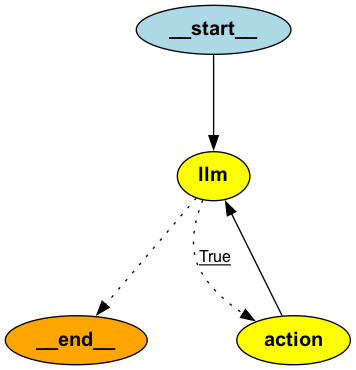

In [8]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [9]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in SF'}, 'id': 'call_5vHPuCjTcMnwg9qpcS1BPlIc'}
Back to the model!


In [10]:
result

{'messages': [HumanMessage(content='What is the weather in sf?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5vHPuCjTcMnwg9qpcS1BPlIc', 'function': {'arguments': '{"query":"weather in SF"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6ce7347f-8e25-4462-9cb5-7a221374c4f9-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in SF'}, 'id': 'call_5vHPuCjTcMnwg9qpcS1BPlIc'}]),
  ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\

In [11]:
result['messages'][-1].content

'The current weather in San Francisco is as follows:\n- Temperature: 52.3°F (11.3°C)\n- Condition: Mist\n- Wind: 12.3 mph (19.8 km/h) from WSW\n- Humidity: 94%\n- Pressure: 29.97 in\n- Visibility: 4.0 miles\n- UV Index: 0.3\n\nIs there anything else you would like to know about the weather in San Francisco?'

In [12]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_69PcIopWtPCTMR1CwductUa1'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_Ru7fQG8e0tI8Oe2nsgycVaLM'}
Back to the model!


In [13]:
result['messages'][-1].content

'The weather in San Francisco is currently cloudy with overcast skies. The daytime temperature is around 57°F and drops to 46°F at night. In Los Angeles, it is currently passing clouds with a temperature of 61°F. The forecast for Los Angeles shows a range of 66°F to 46°F with a wind speed of 12 mph from the west.'

In [14]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_pU2Rr8g1yg9pRRPfvMtxhHee'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_k2eDMXte6VMsWug6HnfFZn0n'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Missouri GDP 2024'}, 'id': 'call_gtbafa1jiVc9N8vDCluXVJtL'}
Back to the model!


In [15]:
print(result['messages'][-1].content)

1. The Kansas City Chiefs won the Super Bowl in 2024, defeating the San Francisco 49ers 25-22 in overtime.

2. The headquarters of the Kansas City Chiefs is located in Kansas City, Missouri.

3. As of the third quarter of 2024, Missouri's GDP was approximately $455 billion.
